In [47]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import pprint
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')

# load the mask
with rasterio.open("./ghw2018_snowmelt_data/scene_30m_mask.tif") as raster:
    mask = raster.read(1)

### Load All Data Into a Dict of Arrays Representing Rasters

In [60]:
from os import walk
import re

data_files = []
for (dirpath, dirnames, filenames) in walk('./ghw2018_snowmelt_data'):
    for f in filenames:
        if 'SUPERsnow' in f:
            data_files.append(f)

data = {
    '2014': [],
    '2015': [],
    '2016': []
}

dates = { '2014': [], '2015': [], '2016': [] }

for file in data_files:
    match = re.match("\w{2}(\d{4})(\d{4}).*", file)
    if match:
        if match.group(1) in data.keys():
            with rasterio.open(f'./ghw2018_snowmelt_data/{file}') as raster:
                data[match.group(1)].append(raster.read(1)*mask)
                dates[match.group(1)].append(parser.parse(match.group(1) + match.group(2)))

### Use Xarray to Generate Timepoint-by-timepoint Plots for All Data

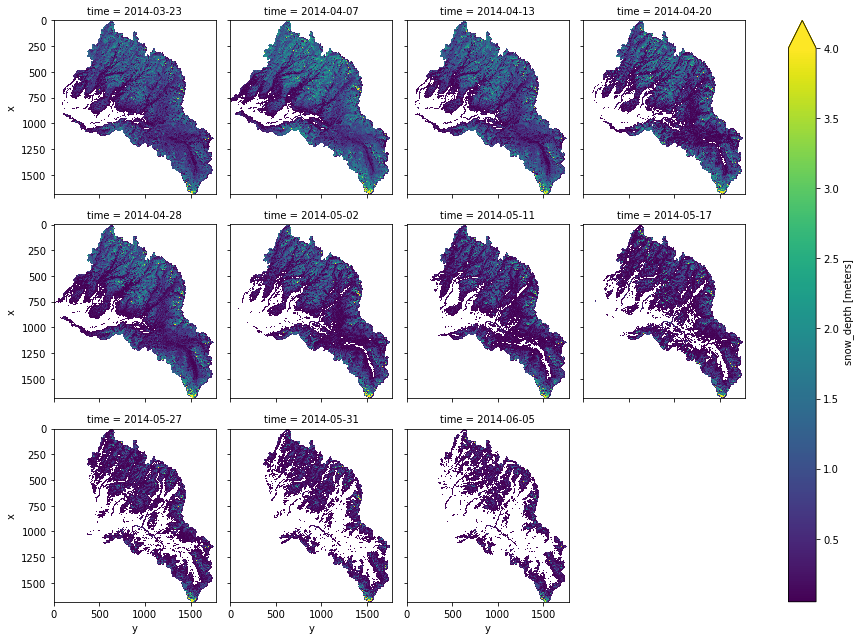

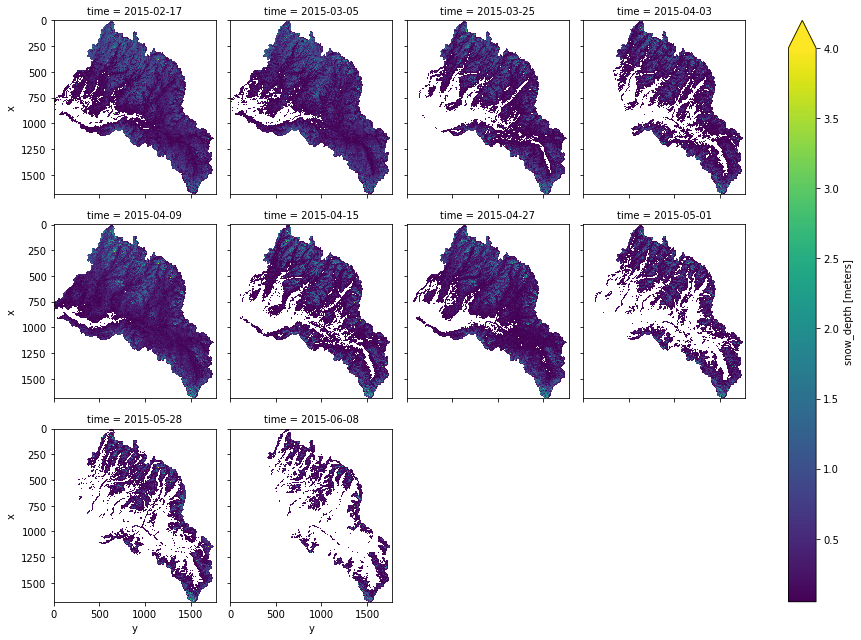

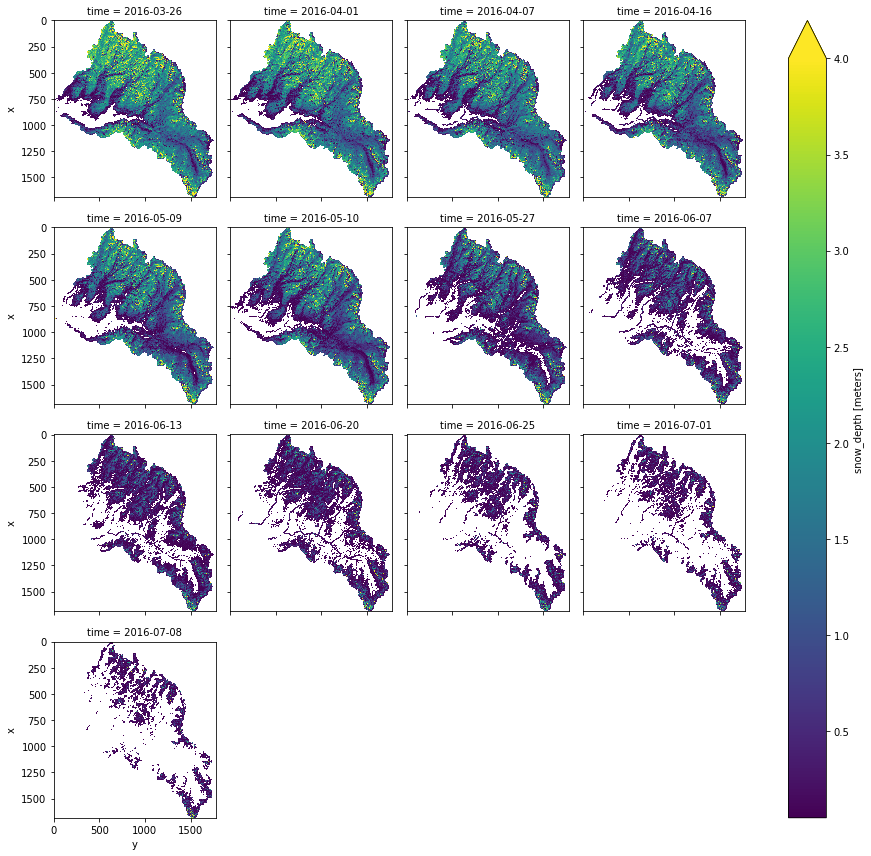

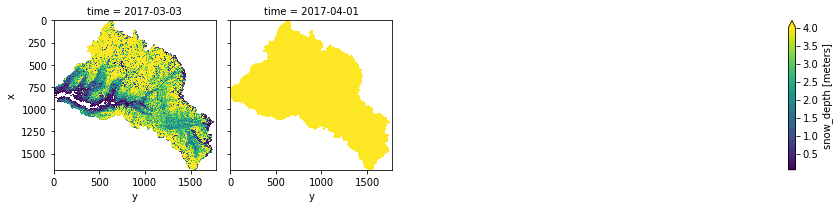

In [54]:
for year,values in data.items():
    data_matrices = np.asarray(values)
    data_array = xr.DataArray(data_matrices,
                    dims=('time','x', 'y'),
                    coords={'x': range(1684), 'y': range(1777),'time': dates[year]},
                    attrs={'units': 'meters'},
                    name='snow_depth')
    data_array.sortby('time').plot(col='time', col_wrap=4, vmax=4)
    plt.gca().invert_yaxis()


### Visualizing Mean Rate of Snowmelt Across the Watershed Overlayed on Aspect

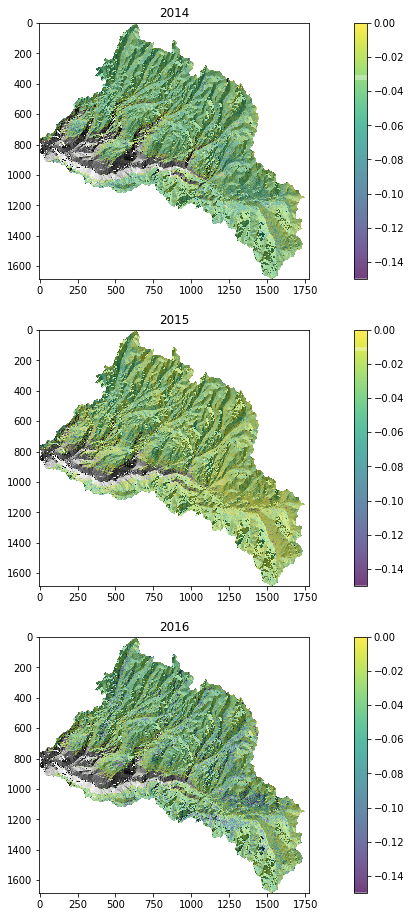

In [74]:
with rasterio.open('./ghw2018_snowmelt_data/aspect30m.tif') as raster:
    aspect = raster.read(1)*mask

plt.figure(figsize=(16,16))
plot_number = 1

for year,values in data.items():
    data_matrices = np.asarray(values)
    data_matrices = np.nan_to_num(data_matrices)
    diffs = np.diff(data_matrices, axis=0)
    # make sure all near-0s are nans and all positive values are nans for calculating snowmelt rate
    modified_diffs = np.copy(diffs)
    modified_diffs[abs(modified_diffs) < 0.001] = np.nan
    modified_diffs[modified_diffs > 0] = np.nan
    
    diffdays = []
    curr_dates = dates[year]

    for i in range(len(curr_dates)):
        if i < len(curr_dates) - 1:
            d1 = parser.parse(f"{curr_dates[i+1]}")
            d2 = parser.parse(f"{curr_dates[i]}")
            diffdays.append((d1 - d2).days)

    for i in range(len(modified_diffs)):
        modified_diffs[i] = modified_diffs[i] / diffdays[i]

    mean_snowmelt_rate = np.nanmean(modified_diffs, axis=0)
    plt.subplot(3,1, plot_number)
    plt.imshow(aspect, cmap='Greys')
    plt.imshow(mean_snowmelt_rate, vmin=-0.15, vmax=0, alpha=0.5)
    plt.title(year)
    plt.colorbar()
    plot_number += 1
